# Lib import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm

# Target data distribution

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Data/

Mounted at /content/drive/
/content/drive/My Drive/Data


In [39]:
filename = 'Data.txt'
df = pd.read_fwf(filename)

In [40]:
df.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Voltage (V),Eigenfrequency (Hz),Quality factor,Displacement mag (nm),Displacement RMS (nm),Vel mag (m/s),Vel mag RMS (m/s),Acc mag (m/s^2),Acc RMS (m/s^2),Effective mass (kg),Noise (kg^2/s^3),TED (W)
0,551.392100,206.029817,100.0,20.468396,27.337469,809.410905,1.433346,244516.16250606137+17.045496236034406i,7172.456557,0.006348,0.004489,1.965658e-08,0.000007,14.984308730720901,10.595529,2.019349e-14,3.418468e-27,9.933654107011143E-15
1,551.392100,206.029817,100.0,20.468396,27.337469,809.410905,1.433346,489152.1226144065+34.09921444709965i,7172.483744,0.003167,0.002239,1.019002e-09,0.000007,29.915279368882892,21.153297,2.019677e-14,6.839695e-27,2.6178511809986413E-14
2,551.392100,206.029817,100.0,20.468396,27.337469,809.410905,1.433346,734034.4588814733+51.17015509062039i,7172.486165,0.002104,0.001488,5.643049e-08,0.000007,44.75080303177741,31.644144,2.018266e-14,1.025665e-26,4.9678389727478896E-14
3,551.392100,206.029817,100.0,20.468396,27.337469,809.410905,1.433346,979304.3930766938+68.28011931669104i,7171.226434,0.001533,0.001111,2.132262e-06,0.000007,58.0291792188436,42.067906,2.016413e-14,1.367364e-26,8.073928834201974E-14
4,1172.102478,379.651846,200.0,18.533070,3.393140,592.749304,9.807538,112805.816662079+4.305307573811354i,13100.784872,0.043501,0.030765,5.311418e-07,0.000022,21.853639607416174,15.455160,1.451218e-13,1.704437e-28,6.023990208675843E-14


In [41]:
data = []

def process_data(df):
    for index in range(df.shape[0]):
        if index % 4 == 0:
            i = 0
            row = df.iloc[index].values.flatten().tolist()
        else:
            row += df.iloc[index, 7:].values.flatten().tolist()
        i += 1
        if i == 4:
            data.append(row)
    return data

data = pd.DataFrame(process_data(df))
data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,551.392100,206.029817,100.0,20.468396,27.337469,809.410905,1.433346,244516.16250606137+17.045496236034406i,7172.456557,0.006348,...,7171.226434,0.001533,0.001111,2.132262e-06,0.000007,58.0291792188436,42.067906,2.016413e-14,1.367364e-26,8.073928834201974E-14
1,1172.102478,379.651846,200.0,18.533070,3.393140,592.749304,9.807538,112805.816662079+4.305307573811354i,13100.784872,0.043501,...,13100.050846,0.025595,0.018105,1.866958e-06,0.000051,202.6858673339763,143.368548,1.450770e-13,6.765369e-28,1.8993438467451283E-13
2,162.989741,883.213702,100.0,48.746775,19.573123,467.657697,29.607379,1029052.7937603326+72.17835812291919i,7128.541162,0.001068,...,7128.317477,0.000216,0.000153,3.634940e-10,0.000004,180.55187844824434,127.669459,2.975456e-14,7.811807e-25,3.2009892122408813E-12
3,1125.934896,849.829193,100.0,21.777872,1.963606,459.408015,10.608546,128330.29472177783+8.80380227743946i,7288.344892,0.043401,...,7287.185252,0.043312,0.030649,5.359753e-06,0.000099,449.8835468543956,318.349281,1.710741e-13,1.030060e-27,7.165893734957774E-13
4,506.536470,493.370771,200.0,48.956604,2.728436,836.414502,22.231017,287791.0660363386+9.901594610489772i,14532.561540,0.021416,...,14534.964747,0.004839,0.003422,3.790371e-08,0.000025,254.0624259180044,179.649363,9.095386e-14,4.237840e-27,3.8172076925991086E-13


In [43]:
def return_neg_frequencies_index(df, freq_indices):
    list_i = []
    list_j = []
    for j in freq_indices:
        for i in range(df.shape[0]):
            if '-' in df.iloc[i,j]:
                list_i.append(i)
                list_j.append(j)
    return list_i, list_j

def del_neg_frequencies(df, freq_indices):
    lst_i, lst_j = return_neg_frequencies_index(data, freq_indices)
    for i in lst_i:
        df.drop(index=i)
    return df

lst_i, lst_j = return_neg_frequencies_index(data, [7, 18, 29, 40])
data = del_neg_frequencies(data, [7, 18, 29, 40])
lst_i, lst_j = return_neg_frequencies_index(data, [7, 18, 29, 40])
print(lst_i)

[3571, 3800, 805, 2460]


In [23]:
def del_im(df, freq_indices):
    for j in freq_indices:
        for i in range(0, df.shape[0]):
            df.iloc[i, j] = float(df.iloc[i, j].split('+', 1)[0])
    return df

data = del_im(data, [7, 18, 29, 40])
data.head()

ValueError: ignored

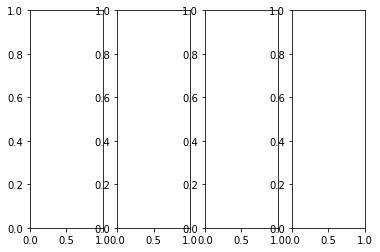

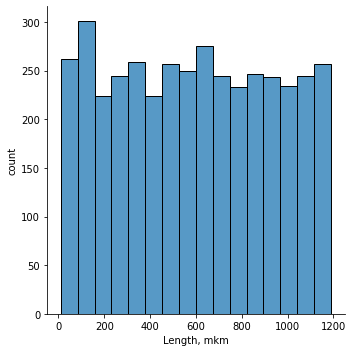

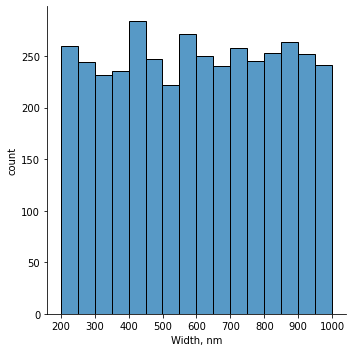

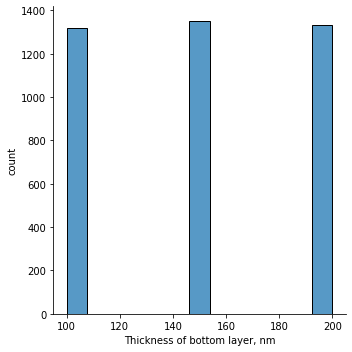

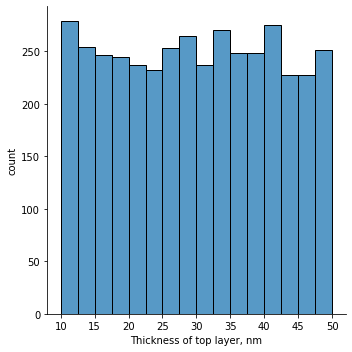

In [18]:
label_dict = {0: 'Length, mkm', 1: 'Width, nm', 2: 'Thickness of bottom layer, nm', 3: 'Thickness of top layer, nm'}

fig, ax = plt.subplots(nrows=1, ncols=4)
for i in range(0,4):
    ax[i] = sns.displot(data.iloc[:, i])
    ax[i].set_axis_labels(label_dict[i], 'count')

fig.show()